In [1]:
,#@title Project Configuration { display-mode: "form" }

PROJECT_ID = "" #@param {type:"string"}
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon'
LOCATION = 'eu'

import os
from google.colab import auth
from google.cloud import bigquery

# Set environment variable for Google Cloud Project
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

print(f"Project ID set to: {PROJECT_ID}")
print(f"Dataset: {DATASET_PROJECT_ID}.{DATASET_ID} (Location: {LOCATION})")

#@title Authenticate User { display-mode: "form" }
auth.authenticate_user()
print('Successfully authenticated')

#@title Initialize Client { display-mode: "form" }
from google.cloud import bigquery

# Default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=f"{DATASET_PROJECT_ID}.{DATASET_ID}")

# Create the BigQuery client
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)

# Enable data table display in Colab
%load_ext google.colab.data_table
from google.colab.data_table import DataTable
DataTable.max_columns = 50
DataTable.max_rows = 20000

print("BigQuery client initialized and ready.")

import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np

config_gbq = {
    "query": {
        "defaultDataset": {"projectId": DATASET_PROJECT_ID, "datasetId": DATASET_ID},
        "location": LOCATION,
    }
}

src_config = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

def q(sql: str) -> pd.DataFrame:
    return pandas_gbq.read_gbq(
        sql,
        project_id=PROJECT_ID,
        configuration=config_gbq,
        use_bqstorage_api=True,
    )

Project ID set to: datathon-484308
Dataset: amsterdamumcdb.van_gogh_2026_datathon (Location: eu)
Successfully authenticated
BigQuery client initialized and ready.


In [10]:
# core settings
MV_CORE = {
    3022875: 'peep_set',
    3012410: 'tv_set',
    3007469: 'rr_set'
}
# airway
AIRWAY = {
    2000000629: 'ett_depth',
    21491186: 'ett_diameter',
    36305611: 'trach_diameter'
}

# ventilation settings
MV_EXTENDED = {
    3000461: 'ps_set',
    2000000209: 'pinsp_above_peep',
    3045410: 'minute_vol_set',
    36304672: 'insp_time_set',
    3000461: 'pressure_support_setting'
}

# ventilation measured
MV_MEASURED = {
    3016226: 'peep_meas',
    2000000238: 'peak_pressure',
    21490854: 'tv_meas'
}

# niv
NIV_STANDARD = {
    2000000188: 'bipap_high',
    2000000191: 'bipap_low',
    2000000203: 'fio2_niv',
    2000000634: 'niv_leckage',
    42868484: 'niv_device' # any specified device in context of peep > 0 indicates NIV
}

# oxygen
O2_THERAPY = {
    3005629: 'o2_flow'
}

# Blood gas analysis
BGA = {
    3027801: 'pao2',
    3027946: 'paco2',
    3019977: 'ph',
    3016502: 'sao2'
}

# vitals
VITALS = {
    40762499: 'spo2',
    3027018: 'hr',
    3004249: 'rr'
}

STANDARD_CONCEPTS = {**MV_CORE, **AIRWAY, **MV_EXTENDED, **MV_MEASURED,
                **NIV_STANDARD, **O2_THERAPY, **BGA, **VITALS}

# --- B. SPECIAL PARAMETERS (Filter by ID + Source Value) ---
# Format: {'id': concept_id, 'source': 'exact string match', 'label': 'column_name'}
# Explanation: there are numerous NIV-markers that are hidden behind shared
# concept-IDs, so we have to filter after source_value.
NIV_SPECIAL_CONFIG = [
    {
        "id": 2000000186,
        "source": "NIV Backup RR (Set)",
        "label": "niv_backup_rr"
    },
    {
        "id": 3024171,
        "source": "Frequentie ingesteld;R UMCA NIV FREQUENTIE S",
        "label": "niv_freq_set"
    },
    {
        "id": 2000000209,
        "source": "Pinsp/IPAP ingesteld;R UMCA NIV IPAP",
        "label": "niv_ipap"
    },
    {
        "id": 3024171,
        "source": "Frequentie gemeten;R UMCA NIV FREQUENTIE GEMETEN",
        "label": "niv_freq_meas"
    },
    {
        "id": 36303816,
        "source": "Tidal volume gemeten ;R UMCA NIV TIDAL VOLUME M",
        "label": "niv_tv_meas"
    },
    {
        "id": 21490754,
        "source": "AMV gemeten;R UMCA NIV MINUUTVOLUME M",
        "label": "niv_mv_meas"
    },
    {
        "id": 3005629,
        "source": "O2 flow;R UMCA NIV O2 FLOW",
        "label": "niv_o2_flow"
    },
    {
        "id": 36304672,
        "source": "Insp tijd (s);R UMCA NIV INSPIRATIE TIJD",
        "label": "niv_insp_time"
    }
]

print("Configuration Loaded.")
print(f"Standard Parameters: {len(STANDARD_CONCEPTS)}")
print(f"Special (Source-Filtered) Parameters: {len(NIV_SPECIAL_CONFIG)}")

Configuration Loaded.
Standard Parameters: 26
Special (Source-Filtered) Parameters: 8


In [12]:
# @title Create Classified Ventilation Table
from google.cloud import bigquery

# --- LOCAL CONFIGURATION ---
MY_NEW_DATASET_ID = "my_ventilation_study"
TARGET_TABLE_NAME = "ventilation_hours_classified_full"

peep_id = 3022875
peak_id = 2000000238

standard_ids = list(STANDARD_CONCEPTS.keys())
special_ids = [item['id'] for item in NIV_SPECIAL_CONFIG]
all_ids_unique = list(set(standard_ids + special_ids))
all_ids_sql = ", ".join(map(str, all_ids_unique))

# --- 2. GENERATE PIVOT SQL ---

# A) Standard Pivot (ID matches -> Value)
pivot_parts = []
for cid, label in STANDARD_CONCEPTS.items():
    pivot_parts.append(f"MAX(CASE WHEN measurement_concept_id = {cid} THEN value_as_number END) AS {label}")

# B) Special Pivot (ID matches AND Source matches -> Value)
for item in NIV_SPECIAL_CONFIG:
    cid = item['id']
    src = item['source']
    lbl = item['label']
    # KORREKTUR: Das '#' wurde entfernt, damit THEN ausgeführt wird
    pivot_parts.append(f"""
        MAX(CASE
            WHEN measurement_concept_id = {cid}
                 AND measurement_source_value = '{src}'
            THEN value_as_number
        END) AS {lbl}
    """)

full_pivot_sql = ",\n        ".join(pivot_parts)


# --- 3. GENERATE CLASSIFICATION LOGIC ---
niv_columns = list(NIV_STANDARD.values()) + [item['label'] for item in NIV_SPECIAL_CONFIG]
niv_check_condition = " OR ".join([f"{col} IS NOT NULL" for col in niv_columns])


# --- 4. ASSEMBLE QUERY ---
query_v2 = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}` AS

WITH hourly_data AS (
    -- Step 1: Fetch raw data
    SELECT
        person_id,
        TIMESTAMP_TRUNC(measurement_datetime, HOUR) AS start_time,
        measurement_concept_id,
        measurement_source_value,
        value_as_number
    FROM `{DATASET_PROJECT_ID}.{DATASET_ID}.measurement`
    WHERE measurement_concept_id IN ({all_ids_sql})
      AND measurement_datetime IS NOT NULL
      AND value_as_number IS NOT NULL
      -- Filter für PEEP > 30 und Peak Pressure > 50
      AND NOT (measurement_concept_id = {peep_id} AND value_as_number > 30)
      AND NOT (measurement_concept_id = {peak_id} AND value_as_number > 50)
),

aggregated AS (
    -- Step 2: Pivot Data
    SELECT
        person_id,
        start_time,
        {full_pivot_sql}
    FROM hourly_data
    GROUP BY person_id, start_time
)

-- Step 3: Classification
SELECT
    *,
    TIMESTAMP_ADD(start_time, INTERVAL 1 HOUR) AS end_time,
    CASE
        -- If any specific NIV marker is present -> NIV
        WHEN ({niv_check_condition}) THEN 'NIV'
        -- If PEEP is present but no NIV marker -> INVASIVE
        WHEN peep_set IS NOT NULL THEN 'INVASIVE'
        ELSE NULL -- No ventilation detected
    END AS ventilation_mode
FROM aggregated
WHERE peep_set IS NOT NULL
ORDER BY person_id, start_time
"""

# --- 5. EXECUTION ---
print(f"Generatng table `{TARGET_TABLE_NAME}`...")
print(f"Classification considers {len(niv_columns)} NIV-specific markers.")

try:
    client.create_dataset(f"{PROJECT_ID}.{MY_NEW_DATASET_ID}", exists_ok=True)
    job = client.query(query_v2)
    job.result()
    print("✅ Success! Table created.")

    # Validation Stats
    print("\n--- New Classification Stats ---")
    stats = client.query(f"""
        SELECT ventilation_mode, COUNT(*) as hours
        FROM `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}`
        GROUP BY ventilation_mode
        ORDER BY hours DESC
    """).to_dataframe()
    display(stats)

except Exception as e:
    print(f"❌ Error: {e}")

Generatng table `ventilation_hours_classified_full`...
Classification considers 13 NIV-specific markers.
✅ Success! Table created.

--- New Classification Stats ---


,ventilation_mode,hours
0,INVASIVE,2519438
1,NIV,207392


In [13]:
# @title Validation & Data Completeness Check
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOCAL CONFIGURATION ---
MY_NEW_DATASET_ID = "my_ventilation_study"
TARGET_TABLE_NAME = "ventilation_hours_classified_full"

# --- 1. GET SCHEMA DYNAMICALLY ---
# We need to know which columns exist in the table to query them
table_ref = client.get_table(f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}")

# Exclude metadata columns from the completeness check
ignore_cols = ['person_id', 'start_time', 'end_time', 'ventilation_mode']
param_cols = [s.name for s in table_ref.schema if s.name not in ignore_cols]

print(f"Analyzing completeness for {len(param_cols)} parameters split by mode...")

# --- 2. SQL QUERY (GROUP BY MODE) ---
# We count non-nulls for every parameter, grouped by the ventilation mode
count_exprs = [f"COUNT({col}) as {col}" for col in param_cols]
sql_cols = ",\n        ".join(count_exprs)

query_split = f"""
    SELECT
        ventilation_mode,
        COUNT(*) as total_hours,
        {sql_cols}
    FROM `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}`
    GROUP BY ventilation_mode
"""

# Execute Query
df_raw = client.query(query_split).to_dataframe()
df_raw.set_index('ventilation_mode', inplace=True)

# --- 3. CALCULATE PERCENTAGES (PYTHON) ---
# We transpose the dataframe so parameters become rows
# Result structure: Index=Parameter, Columns=[INVASIVE_count, NIV_count]
df_transposed = df_raw.T
total_counts = df_transposed.loc['total_hours'] # Extract the row with total counts
df_params = df_transposed.drop('total_hours')   # Keep only parameter rows

# Create a new Summary DataFrame
summary_data = []

for param in df_params.index:
    # Get counts for Invasive
    inv_count = df_params.loc[param, 'INVASIVE'] if 'INVASIVE' in df_params.columns else 0
    inv_total = total_counts['INVASIVE'] if 'INVASIVE' in total_counts.index else 1

    # Get counts for NIV
    niv_count = df_params.loc[param, 'NIV'] if 'NIV' in df_params.columns else 0
    niv_total = total_counts['NIV'] if 'NIV' in total_counts.index else 1

    summary_data.append({
        'Parameter': param,
        'INVASIVE (%)': (inv_count / inv_total) * 100,
        'NIV (%)': (niv_count / niv_total) * 100
    })

df_comparison = pd.DataFrame(summary_data).set_index('Parameter')
df_comparison = df_comparison.sort_values(by='INVASIVE (%)', ascending=False)

# --- 4. DISPLAY RESULTS ---

print(f"Total Hours Analyzed: {int(total_counts.sum()):,}")
print(f" -> Invasive: {int(total_counts.get('INVASIVE', 0)):,}")
print(f" -> NIV:      {int(total_counts.get('NIV', 0)):,}")

print("\n--- Data Completeness Comparison ---")
# Use a background gradient to visually highlight differences
# Green = High completeness, Red = Low completeness
styled_df = df_comparison.style.background_gradient(cmap='RdYlGn', subset=['INVASIVE (%)', 'NIV (%)'], vmin=0, vmax=100)\
                               .format("{:.1f}")

display(styled_df)

Analyzing completeness for 34 parameters split by mode...
Total Hours Analyzed: 2,726,830
 -> Invasive: 2,519,438
 -> NIV:      207,392

--- Data Completeness Comparison ---


,INVASIVE (%),NIV (%)
Parameter,,
peep_set,100.0,100.0
peak_pressure,95.7,58.2
rr_set,65.2,13.1
pinsp_above_peep,58.0,53.8
spo2,49.2,36.5
peep_meas,46.1,52.1
hr,44.8,50.8
minute_vol_set,35.5,18.7
insp_time_set,28.4,6.5


In [15]:
# --- 1. Episode Extraction Logic ---
# This query identifies contiguous episodes of the same ventilation mode.
# It bridges gaps of less than 3 hours as per your requirement.

EPISODE_TABLE = "ventilation_episodes"

query_episodes = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{EPISODE_TABLE}` AS
WITH lag_data AS (
    -- Get the end time of the previous hour for the same patient and mode
    SELECT
        *,
        LAG(end_time) OVER(PARTITION BY person_id, ventilation_mode ORDER BY start_time) AS prev_end_time
    FROM `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}`
),
new_episode_flag AS (
    -- Mark a new episode if the gap is >= 3 hours or no previous record exists
    SELECT
        *,
        CASE
            WHEN prev_end_time IS NULL OR TIMESTAMP_DIFF(start_time, prev_end_time, HOUR) >= 3
            THEN 1 ELSE 0
        END AS is_new_episode
    FROM lag_data
),
episode_ids AS (
    -- Assign a unique ID to each contiguous segment
    SELECT
        *,
        SUM(is_new_episode) OVER(PARTITION BY person_id, ventilation_mode ORDER BY start_time) AS ep_group_id
    FROM new_episode_flag
),
episode_bounds AS (
    -- Aggregate hours into episodes and find start/end timestamps
    SELECT
        person_id,
        ventilation_mode,
        ep_group_id,
        MIN(start_time) AS ep_start,
        MAX(start_time) AS ep_last_hour_start,
        MAX(end_time) AS ep_end,
        TIMESTAMP_DIFF(MAX(end_time), MIN(start_time), HOUR) AS duration_hours
    FROM episode_ids
    GROUP BY person_id, ventilation_mode, ep_group_id
)
-- Final Selection: Join back to hourly table to get start/end parameter snapshots
SELECT
    b.*,
    -- Parameters at the very beginning of the episode
    s.peep_set AS peep_start,
    s.peak_pressure AS peak_press_start,
    s.rr_set AS rr_start,
    s.tv_set AS tv_start,
    -- Parameters at the very end (last recorded hour) of the episode
    e.peep_set AS peep_end,
    e.peak_pressure AS peak_press_end,
    e.rr_set AS rr_end,
    e.tv_set AS tv_end
FROM episode_bounds b
JOIN `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}` s
  ON b.person_id = s.person_id AND b.ep_start = s.start_time
JOIN `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{TARGET_TABLE_NAME}` e
  ON b.person_id = e.person_id AND b.ep_last_hour_start = e.start_time
"""

print("Extracting episodes and calculating parameters...")
client.query(query_episodes).result()
print(f"✅ Table `{EPISODE_TABLE}` created successfully.")


Extracting episodes and calculating parameters...
✅ Table `ventilation_episodes` created successfully.


/tmp/ipython-input-55703863.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_episodes, x='ventilation_mode', ax=axes[1,1], palette='Set2')


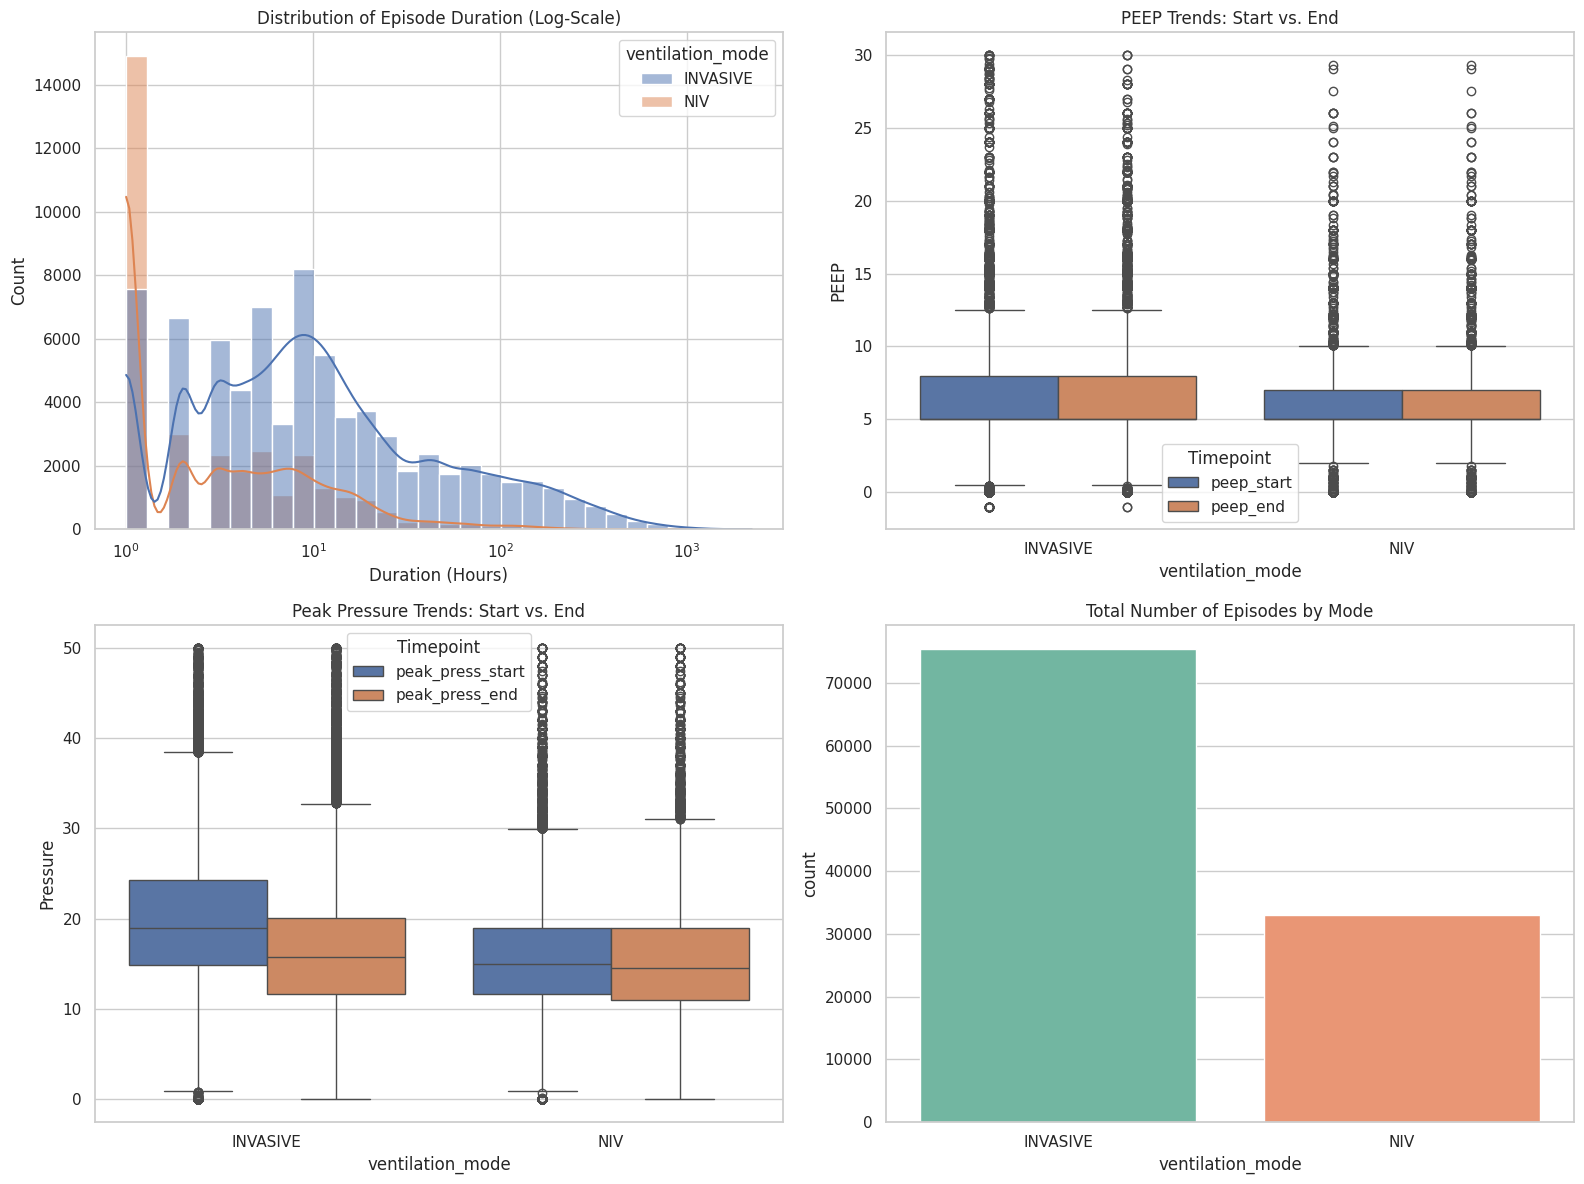


--- Episode Duration Statistics (Hours) ---


,count,mean,median,std,max
ventilation_mode,,,,,
INVASIVE,75458,35.54,8.0,84.21,2213
NIV,32932,6.94,2.0,17.99,699



--- Average Parameter Changes (Start vs End) ---


,peep_start,peep_end,peak_press_start,peak_press_end
ventilation_mode,,,,
INVASIVE,6.22,6.21,19.55,16.80
NIV,5.96,5.91,16.05,15.56


In [16]:

# --- 2. Load and Analyze Episodes ---
df_episodes = client.query(f"SELECT * FROM `{PROJECT_ID}.{MY_NEW_DATASET_ID}.{EPISODE_TABLE}`").to_dataframe()

# --- 3. Visualization: Comparison of IMV vs NIV ---
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Episode Duration Distribution (Log-Scale for better visibility of outliers)
sns.histplot(data=df_episodes, x='duration_hours', hue='ventilation_mode', bins=30, kde=True, ax=axes[0,0], log_scale=(True, False))
axes[0,0].set_title('Distribution of Episode Duration (Log-Scale)')
axes[0,0].set_xlabel('Duration (Hours)')

# B. PEEP Comparison: Start vs. End
peep_df = df_episodes.melt(id_vars=['ventilation_mode'], value_vars=['peep_start', 'peep_end'],
                           var_name='Timepoint', value_name='PEEP')
sns.boxplot(data=peep_df, x='ventilation_mode', y='PEEP', hue='Timepoint', ax=axes[0,1])
axes[0,1].set_title('PEEP Trends: Start vs. End')

# C. Peak Pressure Comparison: Start vs. End
press_df = df_episodes.melt(id_vars=['ventilation_mode'], value_vars=['peak_press_start', 'peak_press_end'],
                            var_name='Timepoint', value_name='Pressure')
sns.boxplot(data=press_df, x='ventilation_mode', y='Pressure', hue='Timepoint', ax=axes[1,0])
axes[1,0].set_title('Peak Pressure Trends: Start vs. End')

# D. Total Episode Counts
sns.countplot(data=df_episodes, x='ventilation_mode', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Total Number of Episodes by Mode')

plt.tight_layout()
plt.show()

# --- 4. Print Summary Statistics ---
print("\n--- Episode Duration Statistics (Hours) ---")
display(df_episodes.groupby('ventilation_mode')['duration_hours'].agg(['count', 'mean', 'median', 'std', 'max']).round(2))

print("\n--- Average Parameter Changes (Start vs End) ---")
param_summary = df_episodes.groupby('ventilation_mode')[['peep_start', 'peep_end', 'peak_press_start', 'peak_press_end']].mean().round(2)
display(param_summary)